In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# Add everything to our paths.
repo = "/pscratch/sd/m/mwhite/AnalyzeLAE/"
for codedir in ["odin","mocks","Cobaya/lss_likelihood"]:
    sys.path.append(repo+codedir)

In [3]:
import json
# Import the Class class.
from classy import Class
# Import velocileptors.
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Gamma function for wp(R).
from scipy.special import gamma
# Spline.
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

## LAE clustering

Let's look at the clustering of LAEs in the mocks, using pre-generated data files created by AbacusHOD and theoretical predictions from Velocileptors.

In [4]:
lae = json.load(open("lae_n501_c000_ph100_s.json","r"))
#lae = json.load(open("lae_n501_c000_ph300_s.json","r"))
#lae = json.load(open("lae_n501_c000_ph310_s.json","r"))
Lbox= lae['BoxSize']
# Print some HOD information.  We will do the full list later.
print("# OmM={:.3f}, H0={:.2f}, z={:.2f}".format(lae['Omega_M'],lae['H0'],lae['Redshift']))
print("# Simulation box of side length {:.0f}Mpc/h.".format(Lbox))
print("# Have information for {:d} HODs.".format(len(lae['mocks'])))
print("# {:33s} {:>6s} {:>10s}".format('HOD params','fsat','nbar'))
for samp in lae['mocks'][:3]:
    hodstr = ""
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    print(hodstr+" {:6.2f} {:10.2e}".format(samp['fsat'],samp['nobj']/Lbox**3))

# OmM=0.315, H0=67.36, z=3.00
# Simulation box of side length 1000Mpc/h.
# Have information for 198 HODs.
# HOD params                          fsat       nbar
  10.80  11.50   0.50   1.00   0.33   0.01   5.60e-02
  10.80  11.80   0.50   1.00   0.33   0.01   5.60e-02
  10.80  12.10   0.50   1.00   0.33   0.01   5.59e-02


### Linear theory

First set up the linear theory and background quantities for this cosmology using CLASS.

In [5]:
# Set up the class instance.
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 50.,
    'z_pk': '0.0,10',
    'lensing': 'yes',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
# Now update some keys with N-body values.
for k in ['n_s','omega_b','omega_cdm',\
          'omega_ncdm','N_ncdm','N_ur']:
    params[k] = lae[k]
params['h'] = lae['H0']/100.0
#
cosmo = Class()
cosmo.set(params)
cosmo.compute()
#
wb = cosmo.omega_b()
wnu= params['omega_ncdm'] # wnu= 0.0106 * params['m_ncdm']
#
print("OmegaM=",cosmo.Omega_m())
print("sigma8=",cosmo.sigma8())
print("hubble=",cosmo.h())
print("omegab=",wb)
print("omegav=",wnu)
#
cosmo.get_current_derived_parameters(['H0','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

OmegaM= 0.3151917236639384
sigma8= 0.8090915366308338
hubble= 0.6736
omegab= 0.02237
omegav= 0.0006442


{'H0': 67.36,
 'Omega_Lambda': 0.6847284676967347,
 'age': 13.797154912501444,
 'conformal_age': 14153.245737831245,
 'Neff': 3.045998221453431,
 'z_reio': 7.9332733154296875,
 '100*theta_s': 1.0418477711693583,
 'rs_rec': 144.5310550407161,
 'rs_d': 147.09704557186203}

In [6]:
zz = lae['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
print("z={:.2f}, f={:.4f}".format(zz,ff))
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kk = np.logspace(-4.0,1.5,1000)
pk = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kk] )
pl = np.array( [cosmo.pk_lin(k*hub,zz)*hub**3 for k in kk] )
#
# Compute the Zeldovich displacement and hence k_{nl}.
knl= 1/np.sqrt( np.trapz(pl,x=kk)/6./np.pi**2 )
print("knl=",knl," h/Mpc.")

z=3.00, f=0.9786
knl= 0.5423896891428361  h/Mpc.


Text(0, 0.5, '$P(k)\\quad [h^{-3}{\\rm Mpc}^3]$')

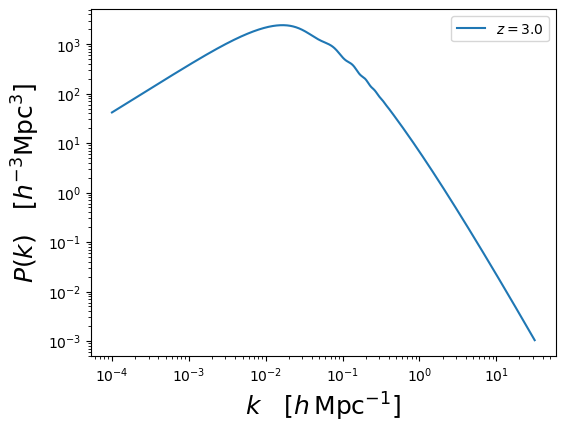

In [7]:
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
ax.plot(kk,pk,label="$z={:.1f}$".format(zz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'$P(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=18)

In [8]:
def xi_mm(rr,zz):
    """Brute force xi_mm(r) for scalar r in Mpc/h."""
    kv = np.linspace(1e-3,50/rr,2500)
    ap = np.cos(np.pi/2*kv/kv[-1]) # Apodize the integral.
    j0 = np.sin(kv*rr)/(kv*rr)
    pv = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kv] )
    xi = np.trapz(kv**2*pv/(2*np.pi**2) * j0 * ap,x=kv)
    return(xi)

In [9]:
# Let's just look at "xi(r)" for the matter spectrum,
# using linear theory just to get a feel for sizes.
for rr in [1.0,2.0]:
    print("xi({:5.2f})={:5.2f}".format(rr,xi_mm(rr,zz))) 

xi( 1.00)= 0.54
xi( 2.00)= 0.28


### LAE data

Get some routines to help massage LAE data.

In [10]:
# Schechter function fits from the literature.  The phi* definition
# is in terms of L, i.e. we need a ln(10) going to lgL [erg/s].
# phi* is in units of Mpc^{-3} and converted to Mpc/h below.
LFlist = []
LFlist.append({'zfid':2.2,'phis':3.37e-4,'Lstar':4.87e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.1,'phis':3.90e-4,'Lstar':8.49e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.7,'phis':3.31e-4,'Lstar':9.16e42,'alpha':-1.80,\
               'ref':'Konno+16'})
#LFlist.append({'zfid':3.7,'phis':3.4e-4,'Lstar':1.02e43,'alpha':-1.50,\
#               'ref':'Ouchi+08'})
LFlist.append({'zfid':5.7,'phis':4.44e-4,'Lstar':9.09e42,'alpha':-1.80,\
               'ref':'Konno+16'})

In [11]:
def nbar_fit(lgL,zz):
    """Computes nbar, in [Mpc/h]^{-3}, given line luminosity lgL [erg/s]
    for LAEs."""
    # Choose the closest redshift in the table.
    delz= np.array([np.abs(zz-lf['zfid']) for lf in LFlist])
    lf  = LFlist[np.argmin(delz)]
    # Get the Schechter paramerers, converting to Mpc/h units.
    hub = cosmo.h()
    phis,lgLstar,alpha = lf['phis']/hub**3,np.log10(lf['Lstar']),lf['alpha']
    # Just brute-force the Schechter integral, it's plenty fast enough.
    logl = np.linspace(lgL,lgLstar+10,1000)
    ll   = 10.0**(logl-lgLstar)
    lf   = np.log(10)*phis * ll**(alpha+1) * np.exp(-ll)
    nbar = np.trapz(lf,logl)
    return(nbar)

In [12]:
def flux2L(zz):
    """Convert a flux in erg/s/cm2 to log10(L) in [erg/s].
    Add the returned value to log10(flux) to get log10(L)."""
    Mpc_cm = 3.086e24 # 1 Mpc in cm.
    dL     = cosmo.luminosity_distance(zz)
    val    = np.log10(4*np.pi)+2*(np.log10(dL)+np.log10(Mpc_cm))
    return(val)

In [13]:
# Some helpful numbers.
flux = 5e-17
lgL  = np.log10(flux) + flux2L(zz)
chi  = cosmo.comoving_distance(zz) * cosmo.h()
#
print("z    ={:5.1f}".format(zz))
print("Flux ={:10.2e} [erg/s/cm^2]".format(flux))
print("lgL  ={:6.2f} [erg/s]".format(lgL))
print("nbar ={:10.2e}".format(nbar_fit(lgL,zz))+r' [Mpc/h]^3')
print("chi  ={:5.0f}Mpc/h".format(chi))

z    =  3.0
Flux =  5.00e-17 [erg/s/cm^2]
lgL  = 42.61 [erg/s]
nbar =  8.61e-04 [Mpc/h]^3
chi  = 4383Mpc/h


In [14]:
# How much would we need to downsample each HOD model to
# match the nbar for this flux limit?
ntar = nbar_fit(lgL,zz) * Lbox**3
print("# {:36s} {:>6s} {:>10s}".format('HOD','fsat','frac'))
for i,samp in enumerate(lae['mocks']):
    hodstr = "{:03d}".format(i)
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    print(hodstr+" {:6.2f} {:10.2e}".format(samp['fsat'],ntar/samp['nobj']))

# HOD                                    fsat       frac
000  10.80  11.50   0.50   1.00   0.33   0.01   1.54e-02
001  10.80  11.80   0.50   1.00   0.33   0.01   1.54e-02
002  10.80  12.10   0.50   1.00   0.33   0.01   1.54e-02
003  10.80  11.50   0.66   1.00   0.33   0.01   1.34e-02
004  10.80  11.80   0.66   1.00   0.33   0.01   1.34e-02
005  10.80  12.10   0.66   1.00   0.33   0.01   1.34e-02
006  10.80  11.50   0.50   1.00   0.50   0.01   1.54e-02
007  10.80  11.80   0.50   1.00   0.50   0.01   1.54e-02
008  10.80  12.10   0.50   1.00   0.50   0.01   1.54e-02
009  10.80  11.50   0.66   1.00   0.50   0.01   1.34e-02
010  10.80  11.80   0.66   1.00   0.50   0.01   1.34e-02
011  10.80  12.10   0.66   1.00   0.50   0.01   1.34e-02
012  10.80  11.50   0.50   1.00   0.66   0.01   1.54e-02
013  10.80  11.80   0.50   1.00   0.66   0.01   1.54e-02
014  10.80  12.10   0.50   1.00   0.66   0.01   1.54e-02
015  10.80  11.50   0.66   1.00   0.66   0.01   1.34e-02
016  10.80  11.80   0.66   1.00

In [15]:
# Table 2 of Khostovan+19: https://arxiv.org/pdf/1811.00556.pdf
# IA427: z=2.51 \pm 0.08
# gam,r0,dr0 = 1.80,4.13,0.42 # Mpc/h.
# IA484: z=2.99 \pm 0.09
# gam,r0,dr0 = 1.80,3.85,0.45 # Mpc/h.
# IA505: z=3.17 \pm 0.09
gam,r0,dr0 = 1.80,3.62,0.52 # Mpc/h.
# IA679: z=4.58 \pm 0.14
# gam,r0,dr0 = 1.80,10.81,1.75 # Mpc/h.
# Compute wp(R) as:
R   = np.logspace(-1,1,25)
wpR = R**(1-gam) * r0**gam * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)

### Compare N-body to observational data

Now we can try to compare the data to our N-body results.  For now we ignore variance reduction or other tricks.

Note the power-law fit being used to summarize the data is not, in fact, a particularly good fit to the data itself so the level of agreement should be judged qualitatively (at best).  In addition the data fit was done neglecting redshift-space distortions, which will affect the result.

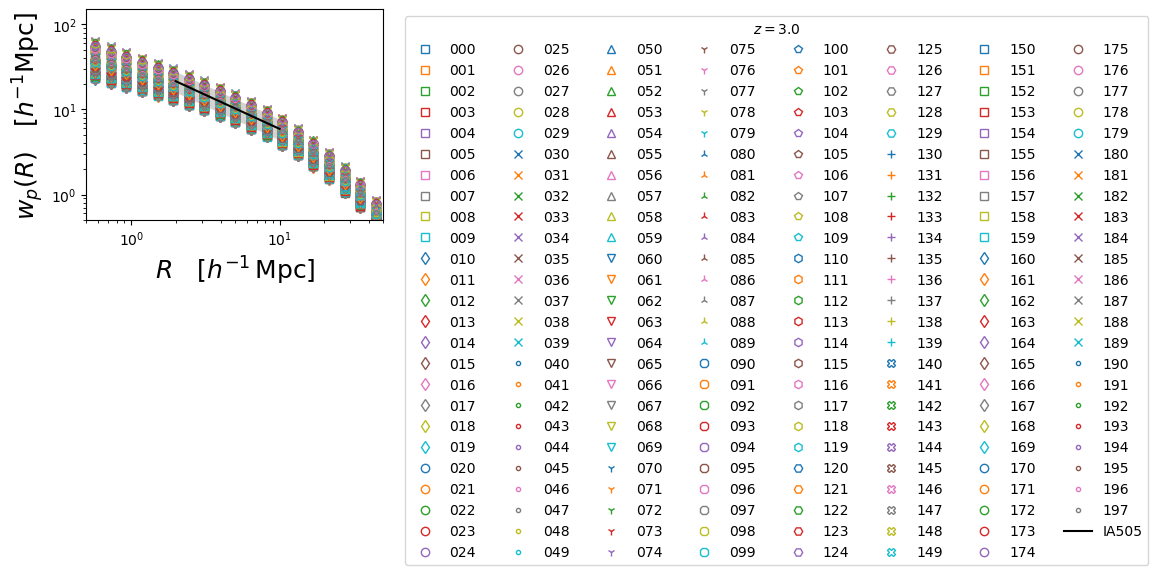

In [16]:
# Begin by looking at the wp(R) results, i.e. without
# redshift-space distortions.
fig,ax = plt.subplots(1,1,figsize=(12,4.5))
# First plot the N-body wp(R).
R = np.array(lae['R'])
marker = ['s','d','o','x','.','^','v','1','2','8','p','h','H','+','X']
for i,samp in enumerate(lae['mocks']):
    ax.plot(R,samp['wp'],marker[(i//10)%len(marker)],color='C'+str(i%10),\
            mfc='None',label="{:03d}".format(i))
# Now plot a power-law fit to the data.  This fit is
# suspect because it was done in the data neglecting
# redshift-space distortions.
R   = np.logspace(0.3,1,25)
wpR = R**(1-gam) * r0**gam * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)
wpup= R**(1-gam) * (r0+dr0)**gam * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)
wpdn= R**(1-gam) * (r0-dr0)**gam * np.sqrt(np.pi)*gamma(gam/2-0.5)/gamma(gam/2)
ax.plot(R,wpR,'k-',label='IA505')
ax.fill_between(R,wpdn,wpup,color='lightgrey')
#
ax.legend(title='$z={:.1f}$'.format(zz),ncol=8,bbox_to_anchor=(1.05,1.0))
ax.set_xlim(0.5, 50.0)
ax.set_ylim(0.5,150.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$R\quad [h^{-1}\,{\rm Mpc}]$',fontsize=18)
ax.set_ylabel(r'$w_p(R)\quad [h^{-1}{\rm Mpc}]$',fontsize=18)
plt.tight_layout()
plt.savefig('lae_N501_wp.png')

### Fit the model to the N-body data

Let's now do a simple-minded fit of the velocileptors LPT model to the N-body data.

In [17]:
class GoodnessFit:
    def __init__(self,dpka,klin,plin,ff,kmin=0.05,kmax=0.40):
        """Takes care of setting up what we need."""
        # Set up the LPT model.
        self.klin= klin.copy()
        self.plin= plin.copy()
        self.ff  = ff
        self.lpt = LPT_RSD(klin,plin,ff,kIR=0.3)
        self.lpt.make_pltable(ff,apar=1,aperp=1,kmin=5e-3,kmax=1.0,nk=100,nmax=4)
        # Copy the data vector.
        self.pka = dpka.copy()
        # and make up an error vector.
        self.kmin = kmin
        self.kmax = kmax
        self.err0 = 0.1 * self.pka[:,1]
        self.err2 = 0.1 * self.pka[:,1] # Std[P2]~P0.
        if kmin>np.min(self.pka[:,0]):
            self.err0[self.pka[:,0]<kmin] = 1e10  # Remove low k.
            self.err2[self.pka[:,0]<kmin] = 1e10  # Remove low k.
        if kmax<np.max(self.pka[:,0]):
            self.err0[self.pka[:,0]>kmax] = 1e10  # Remove high k.
            self.err2[self.pka[:,0]>kmax] = 1e10  # Remove high k.
        #
    def __call__(self,params):
        """Returns chi^2."""
        # Unpack the parameters and compute the theory using the
        # pregenerated LPT tables.
        b1,b2,bs,b3 = params[0],params[1],params[2],0.0
        a0,a2,a4,a6 = params[3],params[4],0.0,0.0
        sn0,sn2,sn4 = params[5],params[6],0.0
        pars = [b1,b2,bs,b3] + [a0,a2,a4,a6] + [sn0,sn2,sn4]
        kl,p0,p2,p4 = self.lpt.combine_bias_terms_pkell(pars)
        # Now interpolate onto the data.
        self.thy0 = Spline(kl,p0)(self.pka[:,0])
        self.thy2 = Spline(kl,p2)(self.pka[:,0])
        # Neglect any covariances, we're assuming that we have
        # an almost noiseless "data vector" so we just want to get
        # close to the data not really do a fit.
        chi2 = np.sum( ((self.pka[:,1]-self.thy0)/self.err0)**2 ) +\
               np.sum( ((self.pka[:,2]-self.thy2)/self.err2)**2 )
        # Since our data are still slightly noisy, let's put in some
        # priors on b2, bs, etc.  This is not rigorous.
        chi2 += ((b2-0.0)/5.0)**2
        chi2 += ((bs-0.0)/5.0)**2
        chi2 += ((a0-0.0)/10.)**2
        chi2 += ((a2-0.0)/10.)**2
        #
        return(chi2)

In [18]:
# Remake the linear theory power spectrum, just to start
# from a clean slate.
zz = lae['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
# Work out the linear theory scaling from z=2 to desired z.
zspecial = 1.0
scaleto  = cosmo.scale_independent_growth_factor(zz)
scaleto /= cosmo.scale_independent_growth_factor(zspecial)
scaleto *= scaleto
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kl = np.logspace(-4.0,1.5,1000)
pl = np.array( [cosmo.pk_cb_lin(k*hub,zspecial)*hub**3 for k in kl] ) * scaleto

In [19]:
# Copy the N-body data into a single array.
# If we use the ZCV data those are in a separate JSON file,
# otherwise we use the larger grid of models.
ihod=41
if False:
    samp=lae['mocks'][ihod]
    pka =np.zeros( (len(samp['pk0']),3) )
    pka[:,0] = lae['k']
    pka[:,1] = samp['pk0']
    pka[:,2] = samp['pk2']
else:
    zcv = json.load(open("lae_n501_c000_ph100_s_zcv.json","r"))
    pka = np.zeros( (len(zcv['k']),3) )
    pka[:,0] = zcv['k']
    pka[:,1] = zcv['pk0']
    pka[:,2] = zcv['pk2']

In [20]:
from scipy.optimize import minimize
#
kmin = 0.02
kmax = 0.45
chi2 = GoodnessFit(pka,kl,pl,ff,kmin,kmax)
par0 = [1.0,0.5,-0.5,-1,20,100,0]
#
res  = minimize(chi2,par0,method='Nelder-Mead',options={'maxfev':5000,'maxiter':5000})
print(res)
# Rerun at the best fit, which also saves
# the predictions inside the class.
chi2min = chi2(res.x) 

 final_simplex: (array([[ 1.04703268e+00,  5.58631125e-01, -4.09368909e-01,
        -1.35162642e+00, -1.45250932e+00,  2.10214774e+01,
         3.97302552e-03],
       [ 1.04703271e+00,  5.58631133e-01, -4.09370384e-01,
        -1.35162271e+00, -1.45251280e+00,  2.10214120e+01,
         3.97305332e-03],
       [ 1.04703271e+00,  5.58630372e-01, -4.09367001e-01,
        -1.35162502e+00, -1.45250914e+00,  2.10214905e+01,
         3.97305104e-03],
       [ 1.04703271e+00,  5.58629199e-01, -4.09371502e-01,
        -1.35162634e+00, -1.45250822e+00,  2.10215150e+01,
         3.97302087e-03],
       [ 1.04703268e+00,  5.58630236e-01, -4.09370015e-01,
        -1.35162515e+00, -1.45250957e+00,  2.10214944e+01,
         3.97303479e-03],
       [ 1.04703271e+00,  5.58629381e-01, -4.09368277e-01,
        -1.35161981e+00, -1.45251284e+00,  2.10214632e+01,
         3.97309660e-03],
       [ 1.04703270e+00,  5.58630107e-01, -4.09370757e-01,
        -1.35162442e+00, -1.45250987e+00,  2.10214603e+01,
 

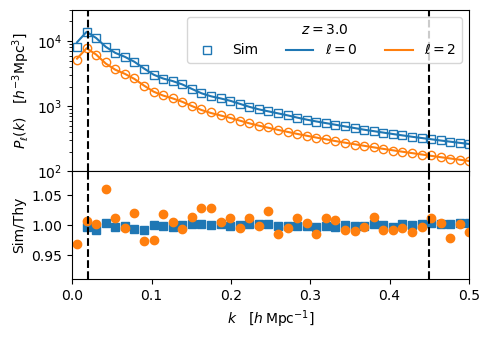

In [21]:
fig,ax = plt.subplots(2,1,figsize=(5,3.5),sharex=True,\
                      gridspec_kw={'hspace':0,'height_ratios':[3,2]})
#
pka,thy0,thy2 = chi2.pka,chi2.thy0,chi2.thy2
ax[0].plot(pka[:,0],pka[:,1],'s',color='C0',mfc='None',label="Sim")
ax[0].plot(pka[:,0],pka[:,2],'o',color='C1',mfc='None')
#
ax[0].plot(pka[:,0],thy0,'-',color='C0',label=r'$\ell=0$')
ax[0].plot(pka[:,0],thy2,'-',color='C1',label=r'$\ell=2$')
#
ax[1].plot(pka[:,0],pka[:,1]/thy0,'s',color='C0')
ax[1].plot(pka[:,0],pka[:,2]/thy2,'o',color='C1')
#
for av in ax:
    av.axvline(kmin,ls='--',color='k')
    av.axvline(kmax,ls='--',color='k')
#
ax[0].legend(title='$z={:.1f}$'.format(zz),ncol=3)
ax[0].set_xlim(0.0,0.50)
ax[1].set_xlim(0.0,0.50)
ax[0].set_ylim(100.,3e4)
ax[1].set_ylim(0.91,1.09)
ax[0].set_xscale('linear')
ax[0].set_yscale('log')
ax[1].set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$')
ax[1].set_ylabel(r'Sim/Thy')
#
plt.tight_layout()
plt.savefig('lae_N501_pkl.pdf')

In [22]:
# Now let's look at the correlation function.
params = res.x.copy()
b1,b2,bs,b3 = params[0],params[1],params[2],0.0
a0,a2,a4,a6 = params[3],params[4],0.0,0.0
sn0,sn2,sn4 = params[5],params[6],0.0  
pars = [b1,b2,bs,b3] + [a0,a2,a4,a6] + [sn0,sn2,sn4]
#
lpt = LPT_RSD(kl,pl,ff,kIR=0.3)
lpt.make_pltable(ff,apar=1,aperp=1,kmin=1e-3,kmax=0.7,nk=100,nmax=4)
xi0,xi2,xi4 = lpt.combine_bias_terms_xiell(pars)

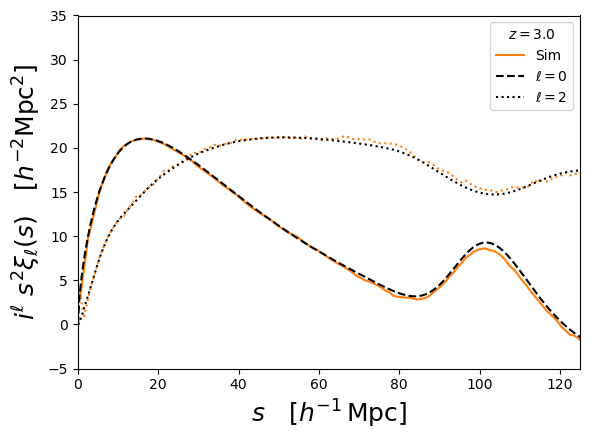

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
# First plot the N-body xi_ell.
#ss   = np.array(lae['R'])
#s2   = ss**2
#icol = 1
#for samp in lae['mocks'][ihod:ihod+1]:
#    ax.plot(ss, s2*samp['xi0'],'s-',color='C'+str(icol),\
#            mfc='None',label="{:5.2f}".format(samp['hod'][0]))
#    ax.plot(ss,-s2*samp['xi2'],'o',color='C'+str(icol),mfc='None')
#    ax.plot(ss, s2*samp['xi4'],'d',color='C'+str(icol),mfc='None')
#    icol = (icol+1)%10
#
ss = np.array(zcv['r'])
s2 = ss**2
ax.plot(ss, s2*zcv['xi0'],'-',color='C1',label='Sim')
ax.plot(ss,-s2*zcv['xi2'],':',color='C1')
#
ax.plot(xi0[0], xi0[0]**2*xi0[1],'k--',label=r'$\ell = 0$')
ax.plot(xi2[0],-xi2[0]**2*xi2[1],'k:' ,label=r'$\ell = 2$')
#
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim( 0,125.0)
ax.set_ylim(-5, 35.0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$s\quad [h^{-1}\,{\rm Mpc}]$',fontsize=18)
ax.set_ylabel(r'$i^\ell\ s^2\xi_\ell(s)\quad [h^{-2}{\rm Mpc}^2]$',fontsize=18)
plt.tight_layout()
plt.savefig('lae_N501_xi.png')

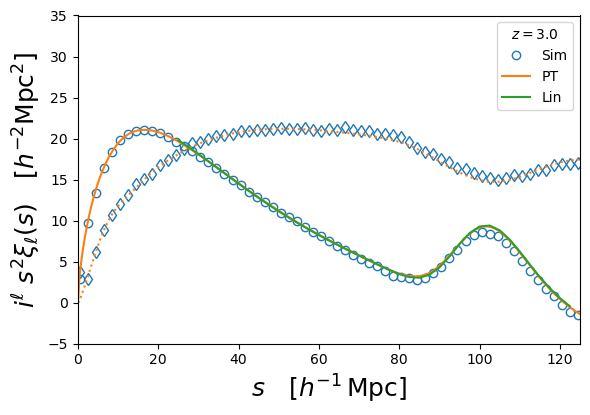

In [24]:
# Make a figure highlighting the BAO peak.
#
#
fig,ax = plt.subplots(1,1,figsize=(6,4.25))
# First plot the N-body xi_ell.
ss = np.array(zcv['r'])[::2]
s2 = ss**2
ax.plot(ss, s2*zcv['xi0'][::2],'o',mfc='None',color='C0',label='Sim')
ax.plot(ss,-s2*zcv['xi2'][::2],'d',mfc='None',color='C0')
#
ax.plot(xi0[0], xi0[0]**2*xi0[1],'-',color='C1',label=r'PT')
ax.plot(xi2[0],-xi2[0]**2*xi2[1],':',color='C1')
#
# Make the linear theory prediction:
bb  = 1+b1
rr  = np.arange(25.0,125.0,2.5)
xir = np.array( [xi_mm(r,zz) for r in rr] )
xil = (bb**2+2./3.*bb*ff+ff**2/5.)*xir
ax.plot(rr, rr**2*xil,'-',color='C2',label=r'Lin')
#
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim( 0,125.0)
ax.set_ylim(-5, 35.0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$s\quad [h^{-1}\,{\rm Mpc}]$',fontsize=18)
ax.set_ylabel(r'$i^\ell\ s^2\xi_\ell(s)\quad [h^{-2}{\rm Mpc}^2]$',fontsize=18)
plt.tight_layout()
plt.savefig('lae_N501_bao.pdf')

In [25]:
from predict_wR import LPTCorrelationFunctions,ThinShellWR
#
ximod = LPTCorrelationFunctions(kl,pl)
thy   = ThinShellWR(ximod,4448.,"lae_cosmos_N501_sfn.txt")
#
Rs    = [5.,10.,15.]
wofR  = thy(Rs,pars)
print(Rs)
print(wofR)

[5.0, 10.0, 15.0]
[0.19394918 0.1045388  0.06520263]


A figure showing the clustering.

In [26]:
dd   = np.loadtxt("mc_cosmos_N501_wR.txt")
corr = np.zeros( (dd.shape[0],dd.shape[0]) )
fin  = open("mc_cosmos_N501_wR.txt","r")
inp  = "# Dummy"
while not inp.startswith("# Correlation matrix"):
    inp = fin.readline()
for i in range(dd.shape[0]):
    inp = fin.readline()[1:]
    xx  = [float(x) for x in inp.split()]
    for j in range(dd.shape[0]):
        corr[i,j] = xx[j]
cov = np.zeros_like(corr)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        cov[i,j]=dd[i,2]*corr[i,j]*dd[j,2]
err = np.sqrt(np.diag(cov))

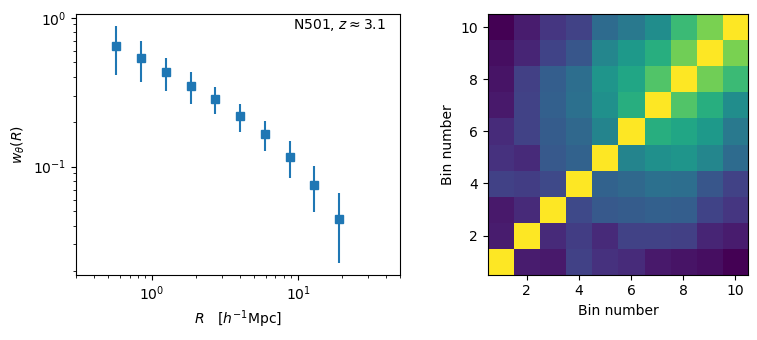

In [27]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))
#
ax[0].errorbar(dd[:,0],dd[:,1],yerr=err,fmt='s')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(0.3,50.)
ax[0].set_xlabel(r'$R\quad [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$w_\theta(R)$')
ax[0].text(40.0,0.9,r'N501, $z\approx 3.1$',ha='right',va='center')
#
ax[1].imshow(corr,origin='lower',extent=[0.5,corr.shape[0]+0.5,0.5,corr.shape[1]+0.5])
ax[1].set_xlabel(r'Bin number')
ax[1].set_ylabel(r'Bin number')
#
plt.tight_layout()
plt.savefig('lae_mock_cosmos_N501_wR.png')

# Done